# Fit RTs - AI and EA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from scipy import integrate
from numba import jit

from psiam_utils import rho_A_t_arr_fn, rho_E_t_arr_fn, cum_A_t_arr_fn, cum_E_t_arr_fn, rho_A_t_fn, rho_E_t_fn
from scipy.integrate import quad

In [2]:
with open('psiam_data_5k.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid]

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act]

In [47]:
print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")

V_A: 0.5
theta_A: 1
V_E: 2
theta_E: 5
Num of AI process: 3784/5000


# Plotting both P and CDF of AI and EA

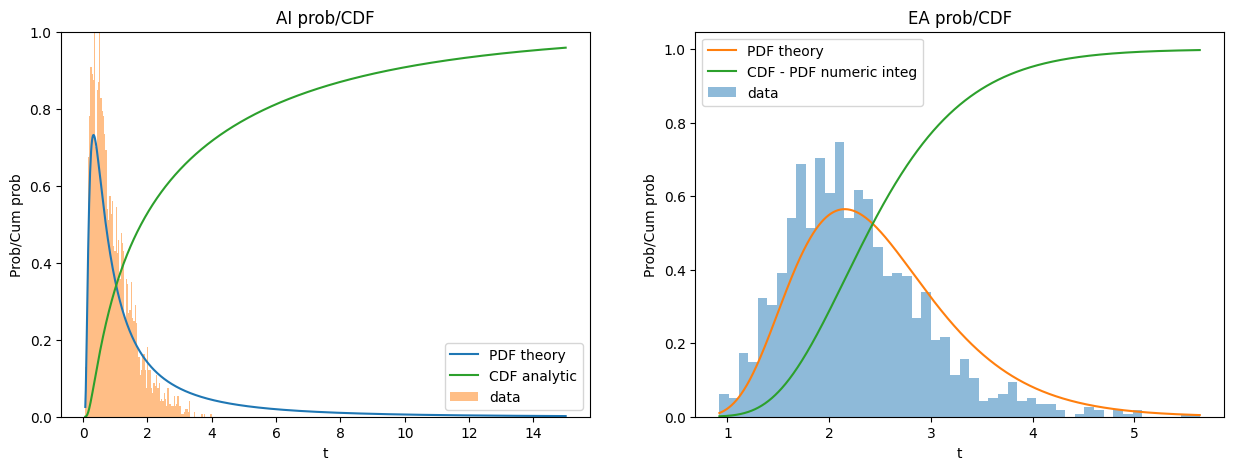

In [31]:
plt.figure(figsize=(15, 5))
# AI
RTs_act_flat = RTs_act.flatten()
t_pts = np.linspace(min(RTs_act_flat), 15, 1000)
# AI prob
norm_const, _ = quad(rho_A_t_fn, 0, np.inf, args=(V_A, theta_A))
rho_t_A_theory = rho_A_t_arr_fn(t_pts, V_A, theta_A)
rho_t_A_theory /= norm_const
plt.subplot(1,2,1)
plt.plot(t_pts, rho_t_A_theory);
# AI data
plt.hist(RTs_act_flat, bins=100, density=True, alpha=0.5);

# AI CDF
cum_A_t_theory = cum_A_t_arr_fn(t_pts, V_A, theta_A)
plt.plot(t_pts, cum_A_t_theory);
plt.ylim(0, 1);
plt.xlabel('t'); plt.ylabel('Prob/Cum prob');plt.title('AI prob/CDF');plt.legend(['PDF theory', 'CDF analytic', 'data']);



plt.subplot(1,2,2)
RTs_evid_flat = RTs_evid.flatten(); K_max = 50
t_pts = np.linspace(min(RTs_evid_flat), max(RTs_evid_flat), 1000)
rho_t_E_theory = rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max)
norm_const, _ = quad(rho_E_t_fn, min(RTs_evid_flat), np.inf, args=(V_E, theta_E, K_max))
rho_t_E_theory /= norm_const

# Data
plt.hist(RTs_evid_flat, density=True, bins=50, alpha=0.5);
# EA PDF
plt.plot(t_pts, rho_t_E_theory);
# EA cdf
min_val = 0.1
cum_E_t_theory = cum_E_t_arr_fn(t_pts, V_E, theta_E, K_max, min_val)
plt.plot(t_pts, cum_E_t_theory);
plt.xlabel('t'); plt.ylabel('Prob/Cum prob');plt.title('EA prob/CDF');plt.legend(['PDF theory', 'CDF - PDF numeric integ', 'data']);

# Fit both

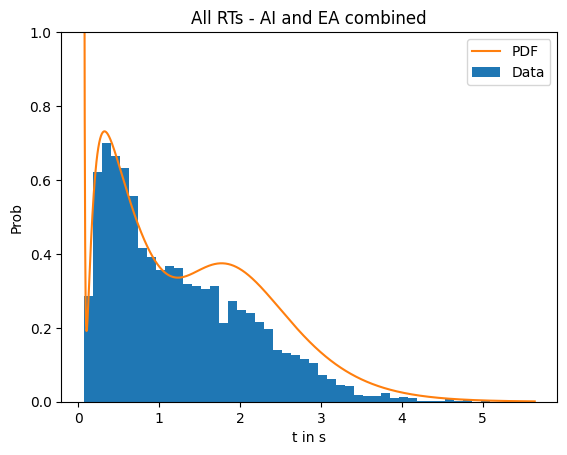

In [40]:
RTs_flat = RTs.flatten()
K_max = 50
# min_val = 0.1
min_val = 0.1
# data
plt.hist(RTs, density=True, bins=50);

# theory
norm_const_A, _ = quad(rho_A_t_fn, 0, np.inf, args=(V_A, theta_A))
norm_const_E, _ = quad(rho_E_t_fn, min_val, np.inf, args=(V_E, theta_E, K_max))

t_pts = np.linspace(min(RTs), max(RTs), 1000)
p_theory  = (rho_A_t_arr_fn(t_pts, V_A, theta_A)/norm_const_A)*(1 - cum_E_t_arr_fn(t_pts, V_E, theta_E, K_max, min_val)) + \
        (rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max)/norm_const_E)*(1 - cum_A_t_arr_fn(t_pts, V_A, theta_A))

plt.plot(t_pts, p_theory)
plt.ylim(0,1); plt.xlabel('t in s'); plt.ylabel('Prob'); plt.title('All RTs - AI and EA combined');
plt.legend(['PDF', 'Data'])

# Why integrating from 0.1 instead of 0 in CDF of EA

In [35]:
c, _ = quad(rho_E_t_fn, 0.1, 1, args=(V_E, theta_E, K_max))
print(f'integ from 0.1 to 1 {c}')
print('XXXXXXXXXXXXXXXXX issue below XXXXXXXXXXXXXXXXXXXXX')
c3, _ = quad(rho_E_t_fn, 0.01, 1, args=(V_E, theta_E, K_max))
print(f'integ from 0.01 to 1 {c3}')
c_2, _ = quad(rho_E_t_fn, 0, 1, args=(V_E, theta_E, K_max))
print(f'integ from 0 to 1 {c_2}')


integ from 0.1 to 1 0.002408806159220129
XXXXXXXXXXXXXXXXX issue below XXXXXXXXXXXXXXXXXXXXX
integ from 0.01 to 1 39.30953789775948
integ from 0 to 1 137.93907034391955


# EA PDF doesn't work well for small t

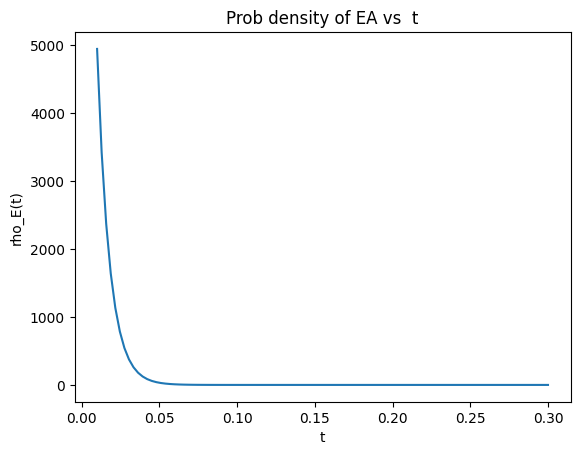

In [49]:
t_pts = np.linspace(0.01,0.3, 100)
plt.plot(t_pts,rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max)); plt.xlabel('t'); plt.ylabel('rho_E(t)'); plt.title('Prob density of EA vs  t');